In [3]:
import librosa
import numpy as np

def extract_audio_features(wav_file_path, feature_type):
    hop_length = 512
    #Load Data
    y, sr = librosa.load(wav_file_path, sr=None)  # Load the audio file

    #Trim audio to remove silence 
    waveform_trimmed, _ = librosa.effects.trim(y, top_db=20)

    # Normalize the audio waveform (optional)
    waveform_normalized = librosa.util.normalize(waveform_trimmed)

    if feature_type == "mfcc":
        print("Extracting MFCCs...")
        features = librosa.feature.mfcc(y=waveform_normalized, sr=sr)
    elif feature_type == "const_Q":
        print("Extracting Constant-Q transform...")
        features = librosa.core.cqt(y=waveform_normalized, sr=sr)
    elif feature_type == "chroma":
        print("Extracting Chroma transform...")
        features = librosa.feature.chroma_stft(y=waveform_normalized, sr=sr)
    elif feature_type == "mel_spec":
        features = librosa.feature.melspectrogram(y=waveform_normalized, sr=sr, hop_length=hop_length)
    elif feature_type == "stft":
        features = librosa.stft(y=waveform_normalized) 
    else:
        raise ValueError("Unsupported feature type specified!")
    return features

# Example usage:
# Feature options: 'mfcc', 'const_Q', 'chroma', 'mel_spec'
# features = extract_audio_features('twink.wav', 'mel_spec')
# print("feature shape: ", features.shape)  # This should print the shape of the extracted MFCC feature matrix.


In [4]:
#1_Hot_encoding 
import numpy as np

# Define vocabulary (example)
vocabulary = ['\n','c', 'd', 'e', 'f', 'g', 'a', 'b', 'i', '\\', '|', ' ', '\'', 's', '2', '4', '8','k', 'y', 'm', 'j', 'o', 'r']  # Notes: C to B, Rest, Whole note

# Create mapping from symbols to indices
symbol_to_index = {symbol: i for i, symbol in enumerate(vocabulary)}



def encode_lilypond_lines_one_hot(lines, symbol_to_index):
    num_symbols = len(symbol_to_index)
    encoded_matrices = []

    total_length = sum(len(line) for line in lines)  # Total length of all lines combined
    # Initialize a large matrix to hold the entire encoding
    encoded_matrix = np.zeros((num_symbols, total_length))

    current_position = 0
    for line in lines:
        # Encode each line
        for char in line:
            if char in symbol_to_index:
                encoded_matrix[symbol_to_index[char], current_position] = 1
            else:
                print(f"Warning: Character '{char}' not found in vocabulary.")
            current_position += 1

    return encoded_matrix


def read_lilypond_from_file(ly_file_path):
    lilypond_notations = []
    start_reading = False
    key_signature = None
    mode = None
    with open(ly_file_path, 'r') as file:
        notation = ""
        for line in file:
            if "\key" in line:
                start_reading = True
                # Extract key signature and mode from the \key line
                # key_line = line.strip().split()
                # key_signature = key_line[1]
                # mode = key_line[2]
            if start_reading:
                for char in line:
                    if char == '}':
                        start_reading = False
                        break  # Stop reading at '}'
                    if char.isalpha() or char in ['\n',"'", ',', '|', '\\', ' ', '/', '2', '4', '8']:  # Include apostrophe, comma, and vertical bar
                        notation += char
                if notation:
                    lilypond_notations.append(notation)
                    notation = ""
    return lilypond_notations

def pullLilypondData(ly_file_path):
    lilypond_notations = read_lilypond_from_file(ly_file_path)
    #print(lilypond_notations)
    encoded_sequences = encode_lilypond_lines_one_hot(lilypond_notations, symbol_to_index)
    #encoded_sequences_array = package_1_hot(encoded_sequences)
    return encoded_sequences




# # # # Example Lilypond notation file path
# ly_file_path = 'Twinkle.ly'

# # # # Read Lilypond notation from the file
# encoded_sequences_array = pullLilypondData(ly_file_path)

# # # print("test")
# # print("printed array: ", encoded_sequences_array)

# # # # Print the shape of the resulting array
# print("Shape of the encoded sequences array:", encoded_sequences_array.shape)

# # # Print the type of the resulting array
# # print("Type of the encoded sequences array:", type(encoded_sequences_array))



In [5]:
import numpy as np

def pad_features(mfcc_features, max_length):
    # mfcc_features is the original feature array
    # max_length is the maximum length that you've chosen based on your dataset
    pad_width = max_length - mfcc_features.shape[1]
    if pad_width > 0:
        return np.pad(mfcc_features, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        return mfcc_features

                                
def pad_lily(lily_hot, max_length):
    # mfcc_features is the original feature array
    # max_length is the maximum length that you've chosen based on your dataset
    pad_width = max_length - lily_hot.shape[1]
    print(pad_width)
    if pad_width > 0:
        return np.pad(lily_hot, pad_width=((0, 0), (0, pad_width)), mode='constant')
    else:
        return lily_hot
                                
#padded_features = pad_features(melSpect_features, 1261)
#padded_features2 = pad_features(melSpect_features_2, 1261)



In [6]:
import os
import numpy as np
import re

# Your existing functions here (extract_audio_features, pad_features, pullLilypondData, etc.)

def find_matching_wav_files(base_name, folder_path):
    pattern = re.compile(re.escape(base_name) + r'(\(\d+\))?\.wav$')
    matching_files = [f for f in os.listdir(folder_path) if pattern.match(f)]
    print(matching_files)
    return matching_files

def bundle_data_for_ml(feature_type):
    folder_path = os.getcwd()  # Get the current working directory
    dataset = []
    ly_files = [f for f in os.listdir(folder_path) if f.endswith('.ly')]

    for i, ly_file in enumerate(ly_files):
        base_name = ly_file.replace('.ly', '')
        matching_wav_files = find_matching_wav_files(base_name, folder_path)

        for wav_file in matching_wav_files:
            wav_path = os.path.join(folder_path, wav_file)
            audio_features = extract_audio_features(wav_path, feature_type)
            print(audio_features.shape)
            padded_features = pad_features(audio_features, 4000)
            ly_features = pullLilypondData(ly_file)
            padded_lily = pad_lily(ly_features, 250)
            dataset.append((padded_features, padded_lily))

    return dataset

# Feature options: 'mfcc', 'const_Q', 'chroma', 'mel_spec', "stft"
dataset = bundle_data_for_ml('mel_spec')
print(f"Total datasets bundled: {len(dataset)}")



['A_Major_Scale_1(0).wav', 'A_Major_Scale_1(2).wav', 'A_Major_Scale_1(3).wav', 'A_Major_Scale_1.wav']
(128, 836)
141
(128, 885)
141
(128, 839)
141
(128, 836)
141
['C_Major_Scale_1(0).wav', 'C_Major_Scale_1(3).wav', 'C_Major_Scale_1.wav']
(128, 842)
163
(128, 852)
163
(128, 842)
163
[]
['D_Major_Scale_1(3).wav']
(128, 859)
153
['D_Major_Scale_2(0).wav', 'D_Major_Scale_2(1).wav', 'D_Major_Scale_2(2).wav', 'D_Major_Scale_2(3).wav', 'D_Major_Scale_2.wav']
(128, 1788)
58
(128, 1639)
58
(128, 885)
58
(128, 1640)
58
(128, 1639)
58
['Eb_Major_Scale_1(3).wav']
(128, 826)
141
['E_Major_Scale_1(3).wav']
(128, 839)
143
['F_Major_Scale_1(3).wav']
(128, 838)
155
['G_Major_Scale_1(0).wav', 'G_Major_Scale_1(2).wav', 'G_Major_Scale_1.wav']
(128, 891)
171
(128, 800)
171
(128, 891)
171
[]
[]
Total datasets bundled: 19


Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 0.0189
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0189
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0189
Epoch 4/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - loss: 0.0189
Epoch 5/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0189
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - loss: 0.0189
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - loss: 0.0189
Epoch 8/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - loss: 0.0189
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - loss: 0.0189
Epoch 10/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - loss: 0.0189
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - loss: 0.0189
Epoch 12/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - loss: 0.0189
Epoch 13/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - loss: 0.0189
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - loss: 0.0189
Epoch 15/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 0.0189
Epoch 1

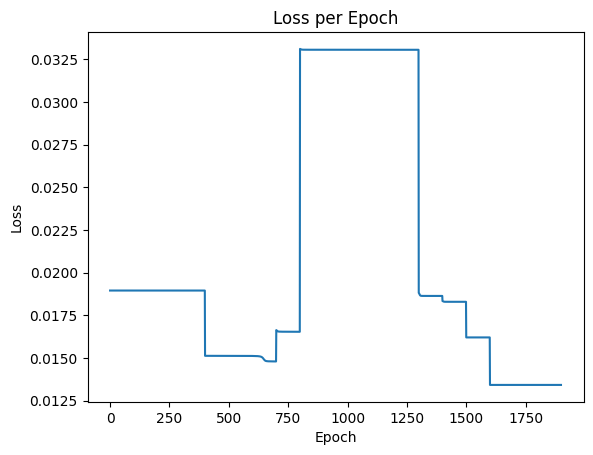

In [28]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.layers import Reshape
import matplotlib.pyplot as plt

# Define the LSTM model
def create_lstm_model(input_shape, output_shape):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=input_shape))
    model.add(Dense(units=np.prod(output_shape), activation='softmax'))  # Output units equal to the flattened output shape
    model.add(Reshape(output_shape))  # Reshape output to match the desired shape
    return model

# Load the dataset generated from the previous code
# Replace this with your actual dataset loading code
# For example:
# dataset = load_dataset()

# Example dataset (replace with your actual dataset loading code)
# dataset = [
#     (np.random.rand(20, 2000), np.random.rand(23, 250)),
#     (np.random.rand(20, 2000), np.random.rand(23, 250))
# ]

# Define input and output shapes
input_shape = dataset[0][0].shape  # Shape of the feature array
output_shape = dataset[0][1].shape  # Shape of the label array

# Create and compile the LSTM model
model = create_lstm_model(input_shape, output_shape)
model.compile(loss='mean_squared_error', optimizer='adam')  # You can change the loss and optimizer as needed

# Train the model using the dataset
losses = []  # List to store loss values per epoch

for features, labels in dataset:
    # Reshape features to match model input shape
    features = np.expand_dims(features, axis=0)
    # Reshape labels to match model output shape
    labels = np.expand_dims(labels, axis=0)
    history = model.fit(features, labels, epochs=100)
    losses.extend(history.history['loss'])  # Append loss values to the list

# Save the model
model_save_path = 'my_model.keras'
model.save(model_save_path)

# Plot the loss per epoch
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.show()


In [25]:
#Prediction 
from tensorflow.keras.models import load_model
hop_length = 512
model_path = 'C:/Users/jzcon/Documents/UT Austin/StatML_HW1/my_model.keras'

model = load_model(model_path)


#Load file into librosa
y, sr = librosa.load('Twinkle.wav')


#Trim audio to remove silence 
waveform_trimmed, _ = librosa.effects.trim(y, top_db=20)

# Normalize the audio waveform (optional)
waveform_normalized = librosa.util.normalize(waveform_trimmed)

#pull mfcc feature
#test_feature = librosa.feature.mfcc(y=waveform_normalized, sr=sr)
test_feature = librosa.feature.melspectrogram(y=waveform_normalized, sr=sr, hop_length=hop_length)
#test_feature = librosa.feature.chroma_stft(y=waveform_normalized, sr=sr)
# Print the shape of the resulting array

test_feature_p = pad_features(test_feature, 4000)
print("Shape of the array:", test_feature_p.shape)
input_data = np.expand_dims(test_feature_p, axis=0)
#mfcc = np.expand_dims(mfccs_features_2, axis=0) 

prediction = model.predict(input_data)
#prediction_reshaped = prediction.reshape(-1, 3, 169, 23)
print(prediction.shape)


# # Thresholding to select max value
# binary_prediction = np.zeros_like(prediction)

max_indices = np.squeeze(np.argmax(prediction, axis=1), axis=0)
print(max_indices)


# # print(max_indices.shape)
# for i, max_index in enumerate(max_indices):
#     binary_prediction[0, i, max_index] = 1
#     print(binary_prediction)
# #binary_prediction[0,0, max_indices[0]] = 1
# print(binary_prediction)
# print(binary_prediction.shape)

# Assuming prediction_reshaped is the output you need to threshold\n",
threshold = 0.00000000000000001
binary_prediction = (prediction > threshold).astype(int)
print(binary_prediction)
print(binary_prediction.shape)


Shape of the array: (128, 4000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
(1, 23, 250)
[11 11 11 11  9 17  3 18 11  2 11  9 19  6 20 21 22  0 11 11 11 11 11 11
 11 11  2 12 11 11  3 12 11  4  8 13 12 11  5 12 11 10 11 12 12 11  7 12
 12 11  8 13 12 12 11  2 12 12 11 12 11 11 11 11 11 11 11 11 11  3 11 12
 11  4  8 12 11 12 11  5 12 12 11  6 12 12 11 10 11  7 12 12 11  1  8 13
 12 12 12 11  2 12 12 12 11  1  8 13 12 12 12 11 10  0 11 11 11 11 11 11
 11 11  7 12 12 11  6 12 12 11  5 12 12 11  4  8 13 12 12 11 10 11  3 12
 12 11  2 12 12 11  1  8 13 12 12 11  7 12 11 10  0 11 11 11 11 11 11 11
 11  6 12 11  5 12 11  4  8 13 12 11  3 12 11 10 11  2 12 11 10  0 11 11
 13 14 18 21 20  5  6  1 11  1  6 11  3  1  5  6  4  1 22 13 14 17  4  5
 11  5 15 18  2 21 14 13 14 15 13 22 21 16 13 15 16  1 14 19  6 16 11  6
 18 20 20  8 12 21  1 19 10  3]
[[[1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  ...
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]
  [1 1 1 ... 1 1 1]]]
(1, 23, 250)


In [26]:
def decode_one_hot_to_lilypond(encoded_matrix, vocabulary):
    lilypond_notation = ""
    # Iterate over each column in the encoded_matrix
    for i in range(encoded_matrix.shape[1]):
        # Find the index of the '1' in this column
        index = np.argmax(encoded_matrix[:, i])
        if index < len(vocabulary):
            lilypond_notation += vocabulary[index]
    return lilypond_notation

# Assuming encoded_matrix is the output from the updated one-hot encoding function
# Example call to the decoder

decoded_lilypond_notation = decode_one_hot_to_lilypond(binary_prediction[0], vocabulary)

# Wrapping the decoded notation in a basic Lilypond score wrapper
lilypond_score = "\\score {\n  \\new Staff {\n    " + decoded_lilypond_notation + "\n  }\n}"
print(lilypond_score)


\score {
  \new Staff {
    


























































































































































































































































  }
}


In [27]:
indexes = [11, 11, 11, 11, 9, 17, 3, 18, 11, 1, 11, 9, 19, 6, 20, 21, 22, 0, 11, 11, 11, 11, 1, 12,
           15, 11, 2, 12, 11, 3, 12, 11, 4, 12, 11, 10, 11, 5, 12, 11, 6, 12, 11, 7, 12, 11, 1, 12,
           12, 11, 10, 0, 11, 11, 11, 11, 1, 12, 12, 11, 7, 12, 11, 6, 12, 11, 5, 12, 11, 10, 11, 4,
           12, 11, 3, 12, 11, 2, 12, 11, 1, 12, 11, 10, 0, 11, 11, 0, 10, 2, 12, 17, 12, 1, 8, 14,
           0, 1, 20, 14, 12, 11, 6, 12, 11, 22, 2, 5, 7, 2, 19, 5, 19, 9, 13, 0, 13, 4, 11, 0, 5, 3,
           10, 16, 7, 16, 9, 11, 1, 22, 6, 8, 10, 18, 12, 18, 12, 5, 22, 19, 17, 11, 8, 5, 19, 14, 18,
           1, 15, 11, 7, 16, 17, 9, 3, 8, 17, 9, 0, 17, 6, 0, 16, 10, 11, 14, 10, 10, 11, 9, 14, 20,
           19, 22, 19, 9, 14, 21, 14, 7, 1, 14, 11, 14, 5, 10, 19, 20, 9, 0, 10, 4, 9, 19, 6, 0, 4, 17,
           4, 6, 13, 3, 4, 11, 6, 4, 19, 16, 6, 4, 12, 2, 11, 6, 21, 19, 6, 11, 12, 17, 20, 21, 12, 10,
           16, 6, 0, 16, 0, 20, 7, 22, 3, 19, 20, 14, 14, 6, 10, 9, 0, 3, 4, 7, 10, 22, 16, 6, 12, 6]

vocabulary = ['\n', 'c', 'd', 'e', 'f', 'g', 'a', 'b', 'i', '\\', '|', ' ', '\'', 's', '2', '4', '8',
              'k', 'y', 'm', 'j', 'o', 'r']

decoded_string = ''.join([vocabulary[idx] for idx in max_indices])
print(decoded_string)


    \key d \major
        d'  e' fis' g' | '' b'' is'' d'' '         e ' fi' ' g'' a'' | b'' cis''' d''' cis''' |
        b'' a'' g'' fis'' | e'' d'' cis'' b' |
        a' g' fis' e' | d' |
  s2yojgac ca ecgafcrs2kfg g4ydo2s24sro8s48c2ma8 ayjji'ocm|e
